In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from astropy.io import fits
from sklearn.decomposition import PCA
import glob2
import os

In [25]:
plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 20

In [53]:
def load_xmmspectra_raw(foldername, background=False):
    """Load XMM spectra with background."""
    pn_src_num, pn_specs, pn_bgs = load_det_spectra(foldername, 'PN',
                                                    background)
    mos_src_num, mos_specs, mos_bgs = load_det_spectra(foldername, 'MOS',
                                                       background)
    return ([pn_src_num, mos_src_num], [pn_specs, mos_specs],
            [pn_bgs, mos_bgs])


def load_det_spectra(foldername, det, background=False):
    """Load XMM spectra corresponding to given detector."""
    if det == 'PN':
        n_channels = 4096
    else:
        n_channels = 2400
    if foldername[-1] != '/':
        foldername = foldername + '/'
    spec_files = glob2.glob(foldername + '*_' + det + '_combined_src_grp1*.ds')
    spec_arr = np.zeros((len(spec_files), n_channels), dtype=np.float64)
    srcnum_arr = np.zeros(len(spec_files), dtype=int)
    if background:
        bgspec_arr = np.zeros((len(spec_files), n_channels), dtype=np.float64)
    else:
        bgspec_arr = None

    for i, spec_file in enumerate(spec_files):
        spec = fits.open(spec_file)
        spec_arr[i] = spec[1].data['counts']
        srcnum_arr[i] = int(spec_file.split('/')[-1].split('_')[0])
        if background:
            bg_file = (foldername + str(srcnum_arr[i]) + '_' + det +
                       '_combined_bkg_grp.ds')
            bg_spec = fits.open(bg_file)
            bgspec_arr[i] = bg_spec[1].data['counts']*(
                spec[1].header['backscal'] / bg_spec[1].header['backscal'])

    return srcnum_arr, spec_arr, bgspec_arr


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return emin, emax, e_centres


def get_counts_enrange(spec, en_range, ebin_channels):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        return np.sum(spec[elow_index:ehigh_index])
    
    return np.sum(spec[:, elow_index:ehigh_index], axis=1), elow_index, ehigh_index
    


57:1: W293 blank line contains whitespace
58:80: E501 line too long (83 > 79 characters)
59:1: W293 blank line contains whitespace


# Checking colors of simulated X-ray sources

In [77]:
def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])



In [78]:
([sim_pn_mask, sim_mos_mask], [sim_pn_specs, sim_mos_specs],
 [sim_pn_bgs, sim_mos_bgs]) = load_sim_xmmspec('../data/sim_msps_highNH_PN_MOS/',
                                               background=True,
                                               basename='msp_highNH_')

2:80: E501 line too long (81 > 79 characters)


In [167]:
def plot_spec_summary(src_spec, bg_spec, ebins, det='', en_range=None):
    """Plot spectra summary"""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    src_counts = get_counts_enrange(src_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    plt.figure()
    plt.xlabel(det + ' Energy (keV)')
    plt.ylabel('Normalized mean spectra')
    plt.plot(
        0.5*(ebins[en_lowindex:en_highindex] +
             ebins[en_lowindex+1:en_highindex+1]), np.mean(net_spec, axis=0))
    plt.xscale('log')
    plt.figure()
    plt.xlabel(r'log$_{10}$ (' + det + ' net counts)')
    plt.ylabel('# per bin')
    results = plt.hist([np.log10(net_counts)[net_counts > 1], np.log10(bg_counts)], bins=20)
    print(results)
    plt.figure()
    plt.xlabel(r'log$_{10}$ (' + det + ' background counts/' + det +
               ' net counts)')
    plt.ylabel('# per bin')
    plt.hist(np.log10(bg_counts/net_counts)[net_counts > 1], bins=20)
    plt.figure()
    plt.xlabel(r'log$_{10}$ (' + det + ' background counts/' + det +
               ' source+bg counts)')
    plt.ylabel('# per bin')
    plt.hist(np.log10(bg_counts/src_counts)[net_counts > 1], bins=20)
    plt.figure()
    plt.hist2d(np.log10(net_counts[net_counts > 1]),
               np.log10(bg_counts/net_counts)[net_counts > 1], bins=20)
    plt.xlabel(r'log$_{10}$(' + det + ' net counts)')
    plt.ylabel(r'log$_{10}$(' + det + ' net counts/' + det +
               ' background counts)')
    plt.colorbar()
    return net_spec, net_counts, en_lowindex, en_highindex

11:5: F841 local variable 'norm_spec' is assigned to but never used
22:80: E501 line too long (92 > 79 characters)


In [168]:
sim_pn_specs[sim_pn_mask].shape

(9174, 4096)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10


(array([[  73.,  148.,  247.,  418.,  612.,  744.,  781.,  761.,  797.,
         709.,  692.,  569.,  450.,  313.,  175.,  116.,   76.,   34.,
          15.,    3.],
       [   0.,    0.,    0.,    0.,    0.,   38.,  509.,  966., 1406.,
        1427., 1689.,  998.,  640.,  441.,  297.,  344.,  247.,  120.,
          31.,   21.]]), array([1.95015734e-03, 2.41920361e-01, 4.81890565e-01, 7.21860769e-01,
       9.61830973e-01, 1.20180118e+00, 1.44177138e+00, 1.68174159e+00,
       1.92171179e+00, 2.16168199e+00, 2.40165220e+00, 2.64162240e+00,
       2.88159261e+00, 3.12156281e+00, 3.36153301e+00, 3.60150322e+00,
       3.84147342e+00, 4.08144363e+00, 4.32141383e+00, 4.56138403e+00,
       4.80135424e+00]), <a list of 2 BarContainer objects>)


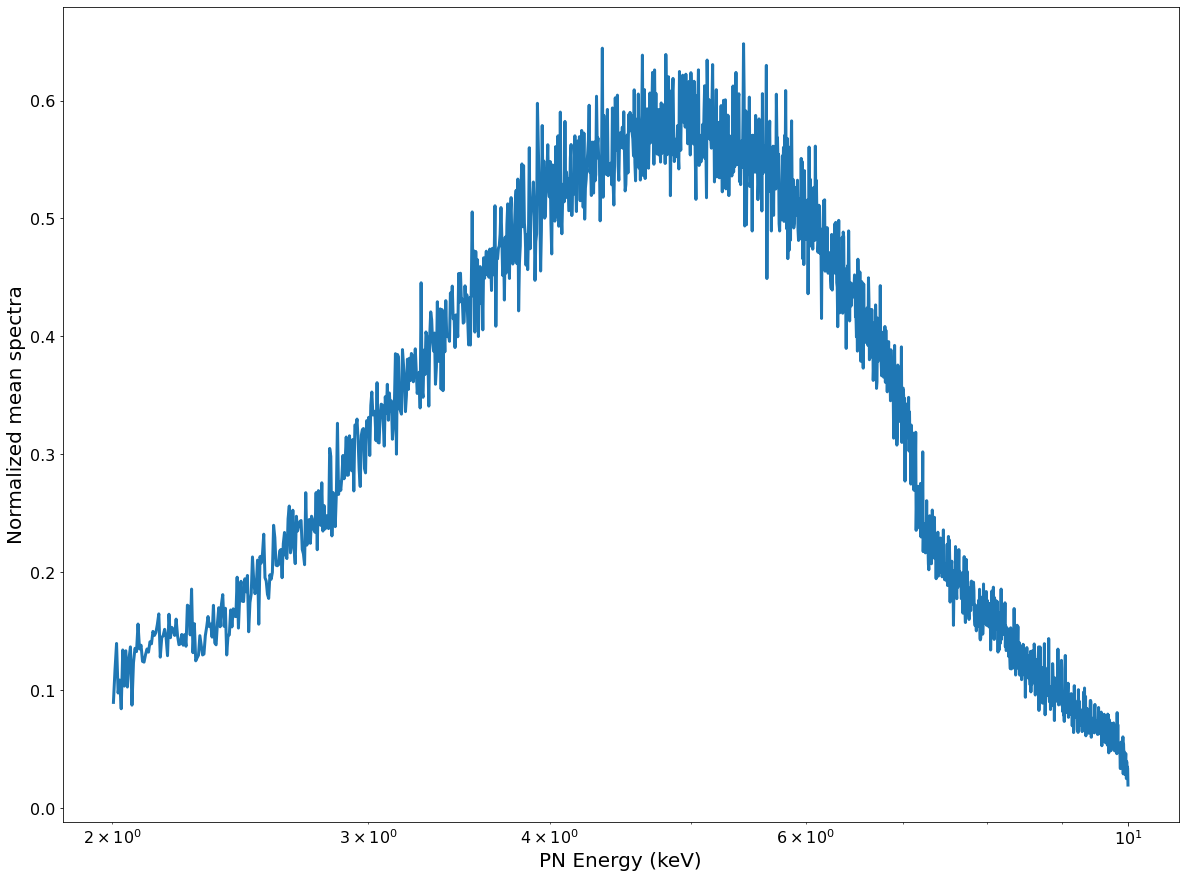

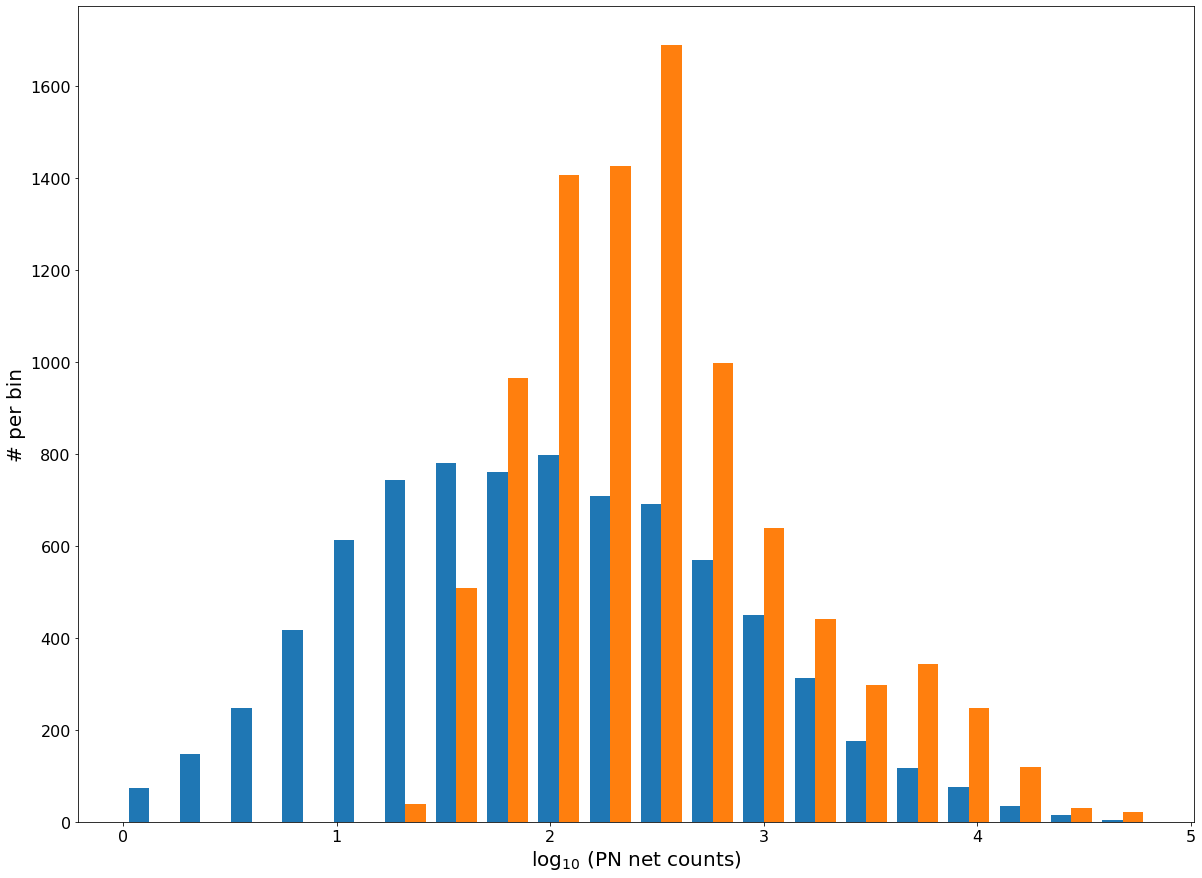

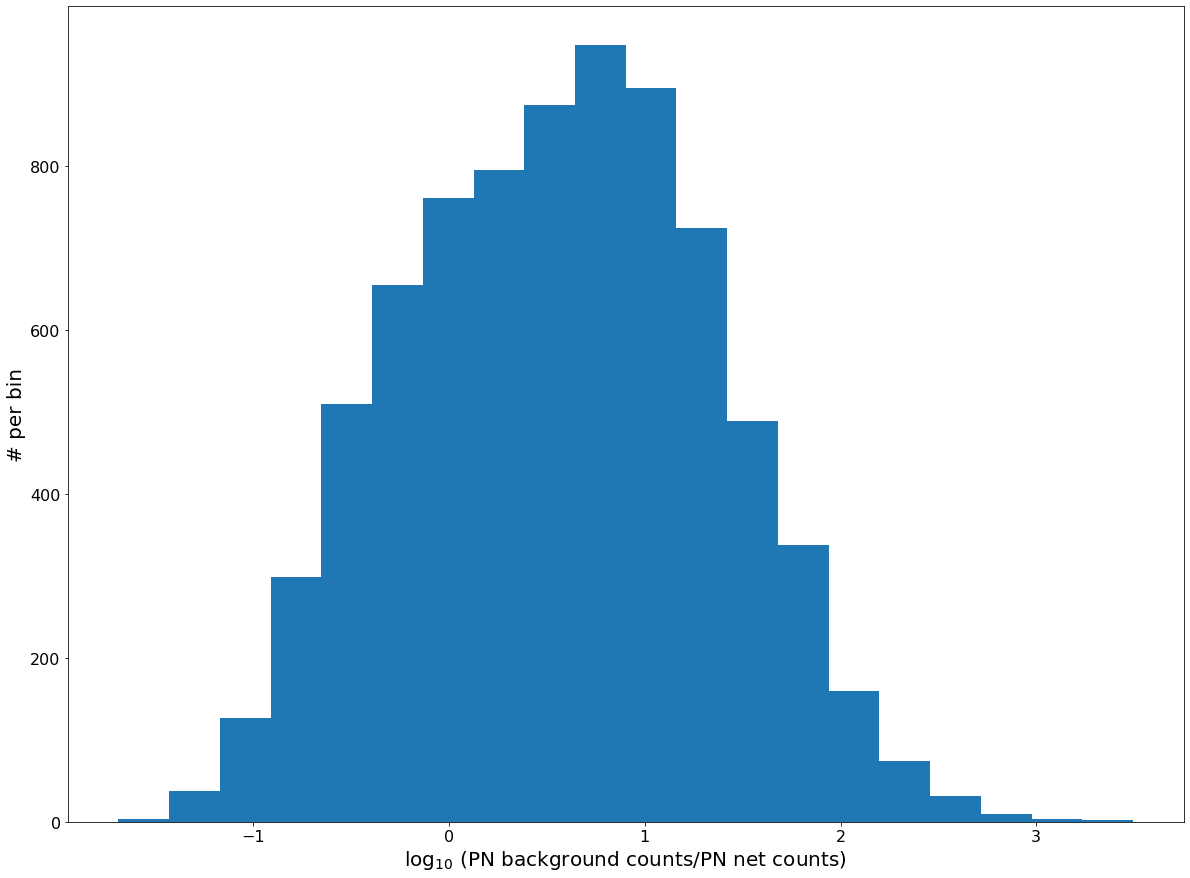

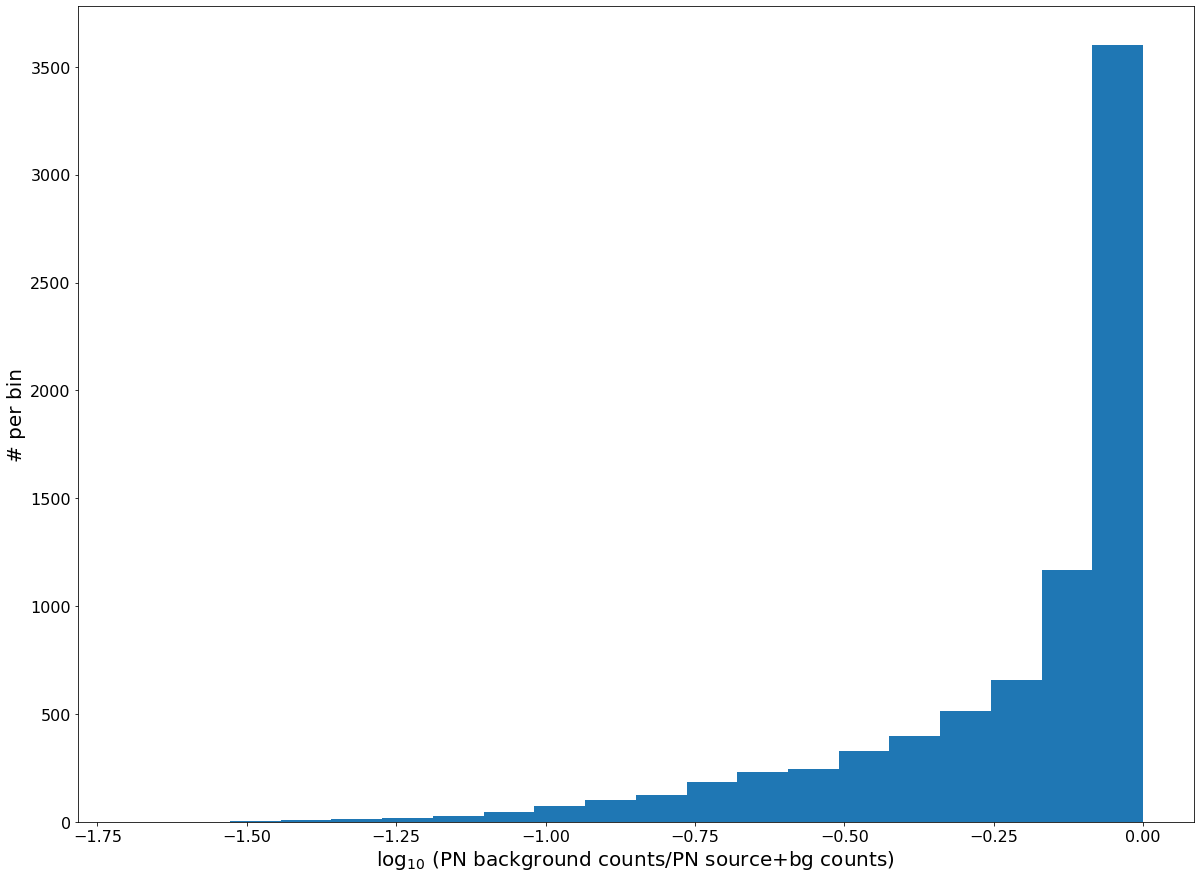

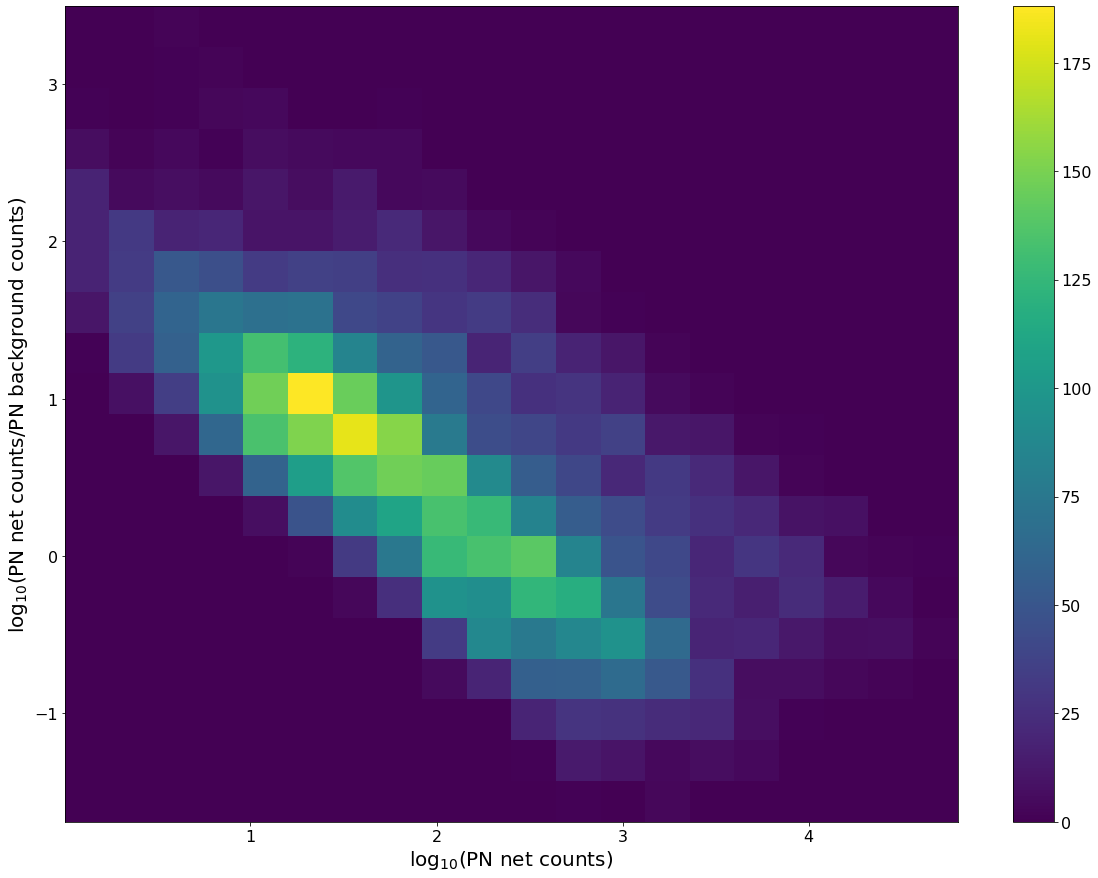

In [179]:
pn_net_spec, pn_net_counts, pn_lowindex, pn_highindex = plot_spec_summary(
    sim_pn_specs[sim_pn_mask], sim_pn_bgs[sim_pn_mask],
    np.append(pn_emin, pn_emax[-1]), det='PN', en_range=[2.0, 10.0])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


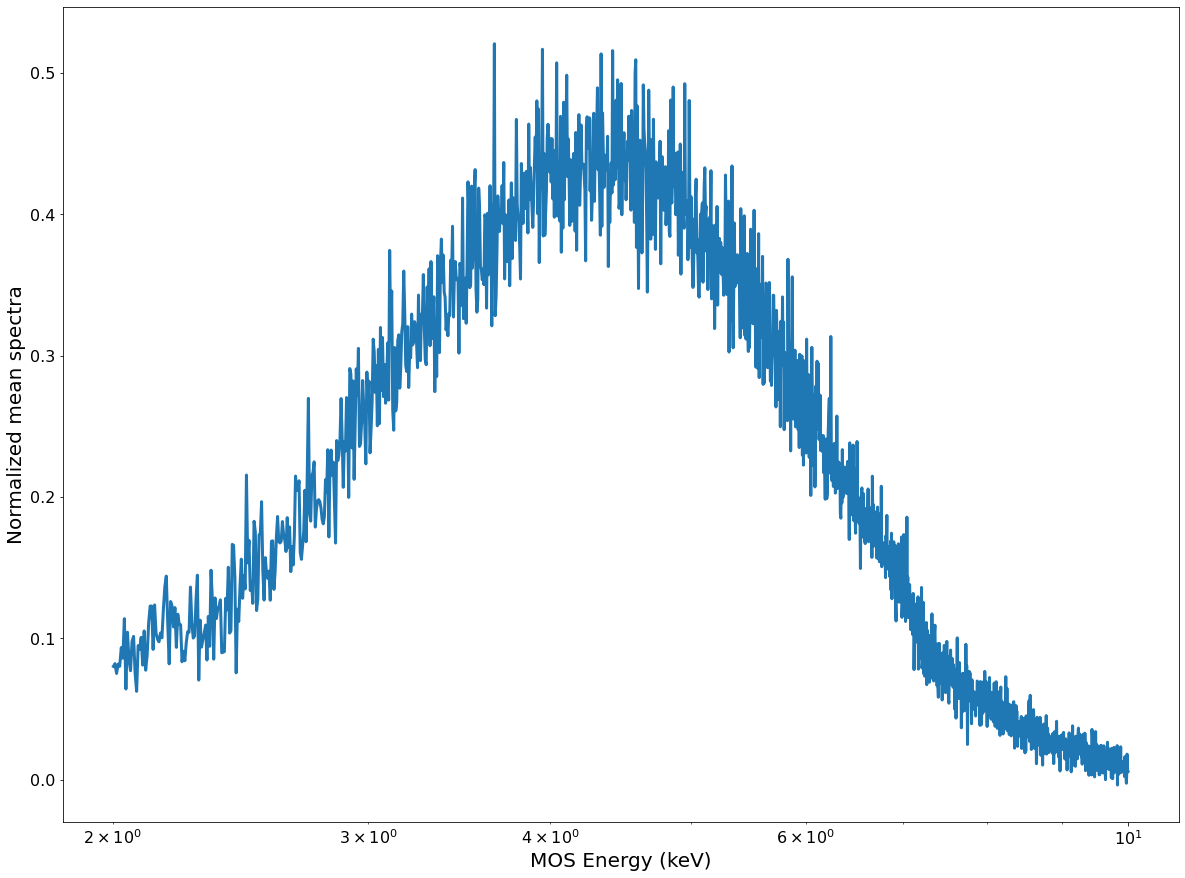

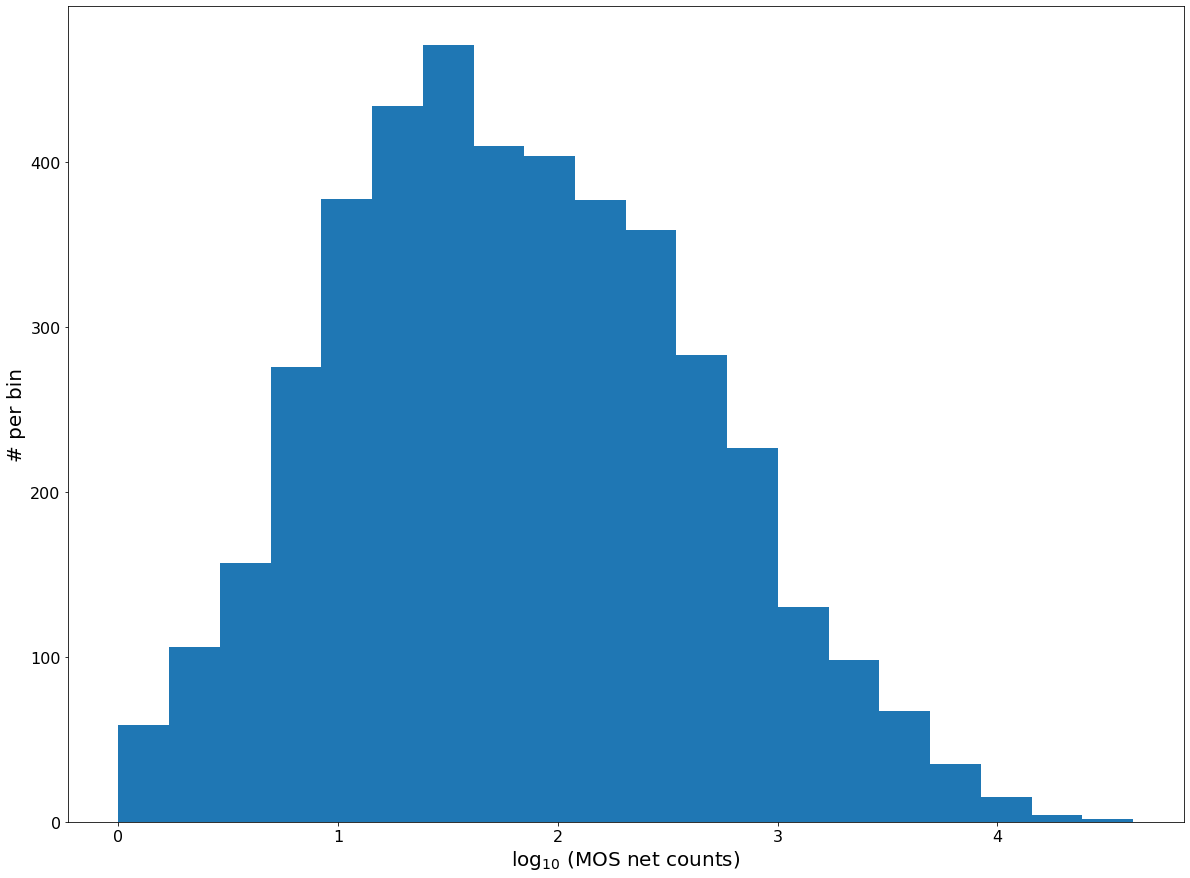

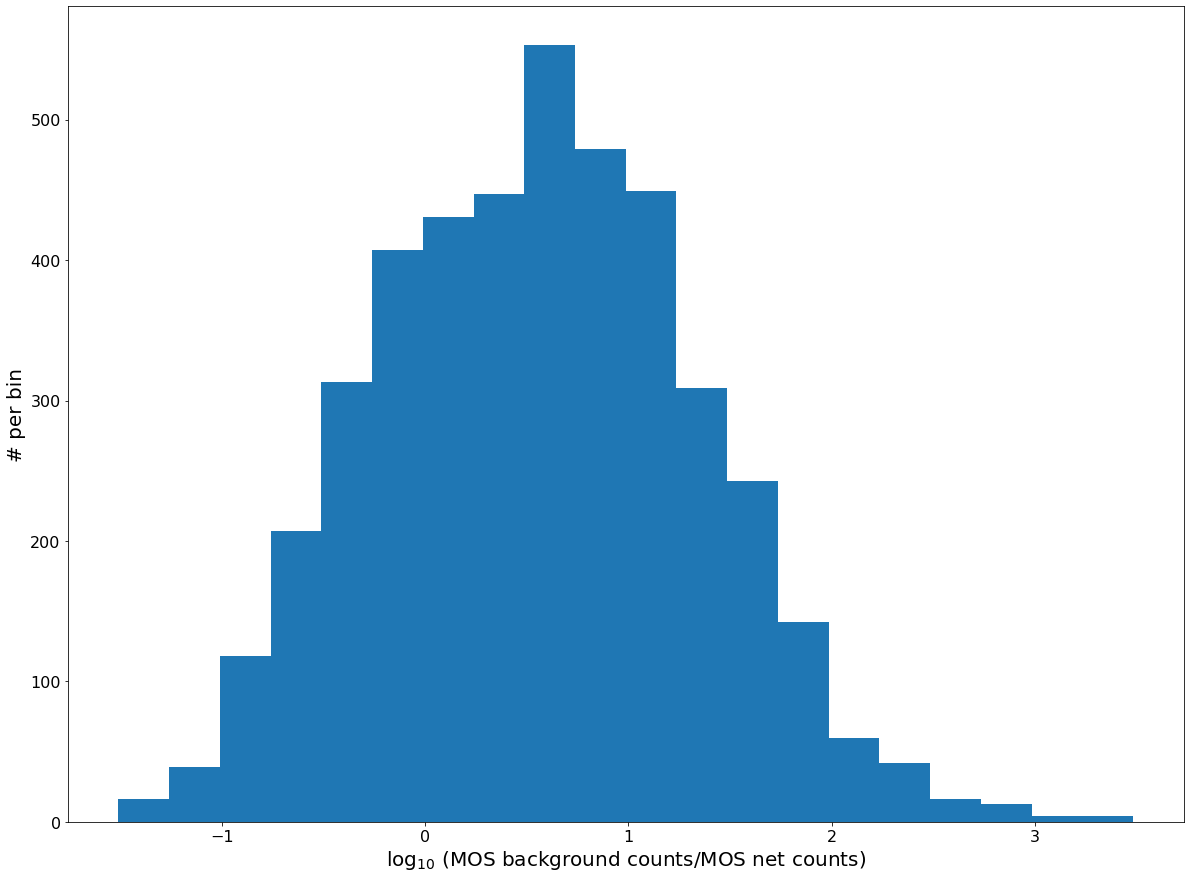

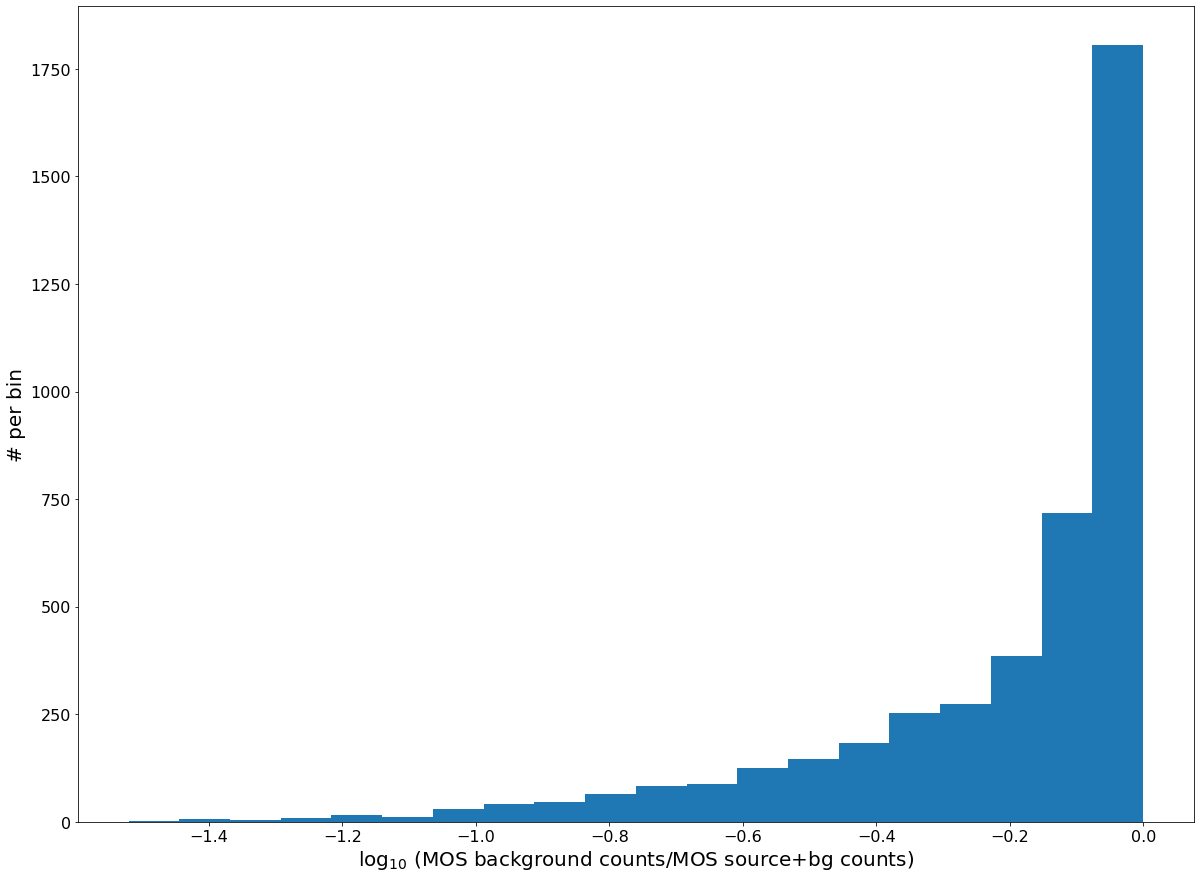

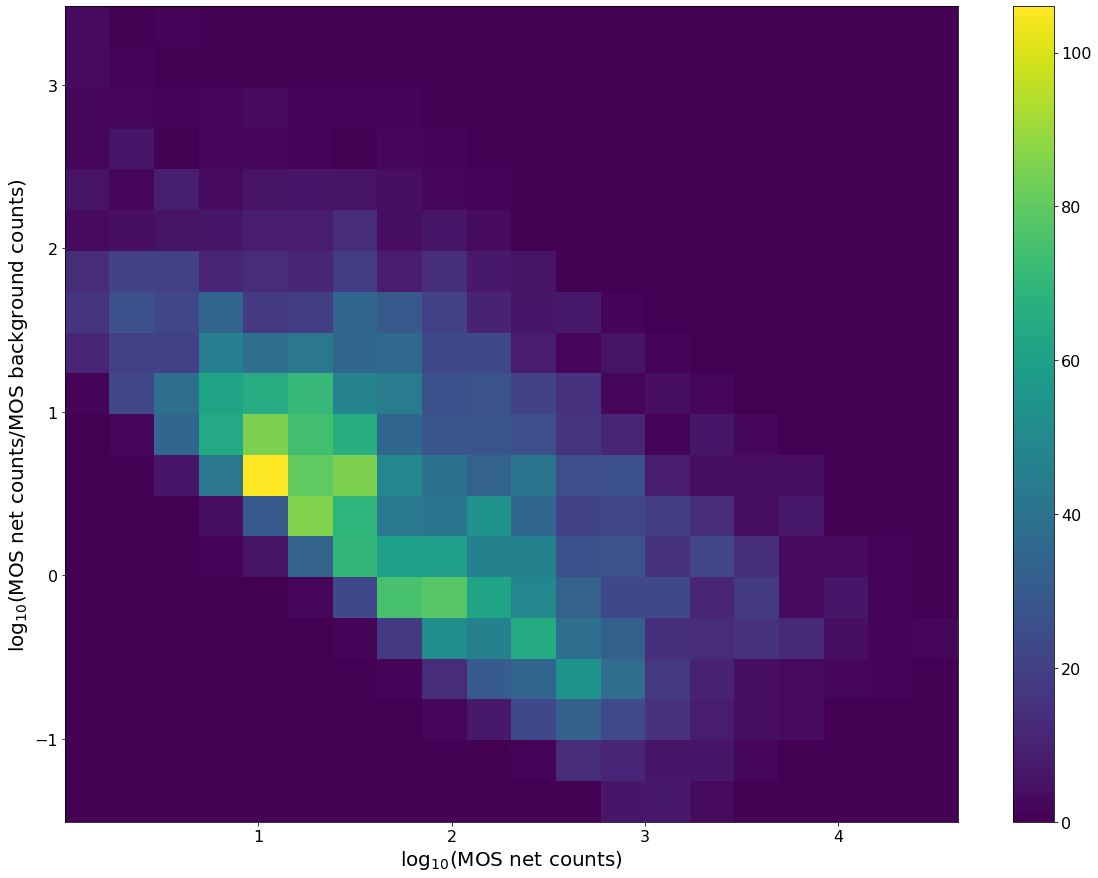

In [102]:
mos_net_spec, mos_net_counts, mos_lowindex, mos_highindex = plot_spec_summary(
    sim_mos_specs[sim_mos_mask], sim_mos_bgs[sim_mos_mask],
    np.append(mos_emin, mos_emax[-1]), det='MOS', en_range=[2, 10])

### Sim PN colors

In [106]:
def get_colors(src_spec, bg_spec, ebins, net_spec=None, range_fe=[6.1, 7.3],
               cont1_range=[5.5, 6.0], cont2_range=[7.4, 7.9]):
    if net_counts is None:
        net_spec = src_spec - bg_spec
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins)[0]
                                   
    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins)[0]
    
    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins)[0]   
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])

8:1: W293 blank line contains whitespace
12:1: W293 blank line contains whitespace
15:70: W291 trailing whitespace


In [134]:
([sim_pn_fe_net, sim_pn_fe_src, sim_pn_fe_bg],
 [sim_pn_cont1_net, sim_pn_cont1_src, sim_pn_cont1_bg],
 [sim_pn_cont2_net, sim_pn_cont2_src, sim_pn_cont2_src]) =  get_colors(
    sim_pn_specs[sim_pn_mask][:, pn_lowindex:pn_highindex],
    sim_pn_bgs[sim_pn_mask][:, pn_lowindex:pn_highindex],
    np.append(pn_emin, pn_emax[-1]), pn_net_spec)

3:59: E222 multiple spaces after operator


In [133]:
sim_pn_specs[sim_pn_mask][:, pn_lowindex:pn_highindex].shape

(9174, 1600)

(0.001, 1000)

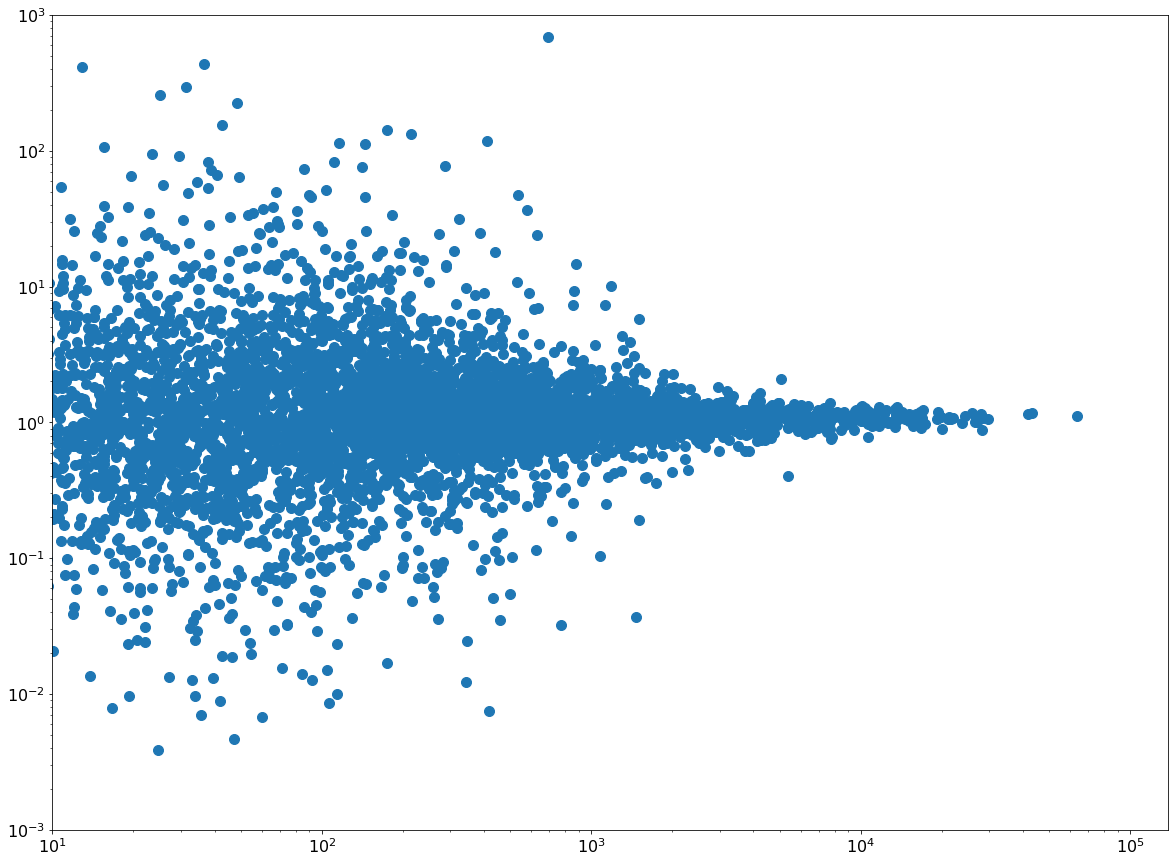

In [152]:
plt.scatter(pn_net_counts, sim_pn_fe_net/(sim_pn_cont1_net+sim_pn_cont2_net))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10)
plt.ylim(0.001, 1000)

In [153]:
sim_pn_bgcounts = np.sum(sim_pn_bgs[sim_pn_mask][:, pn_lowindex:pn_highindex],
                         axis=1)

In [177]:
plt.hist(np.log10(sim_pn_fe_bg), bins=20)

94.54427628817402

(0.01, 100)

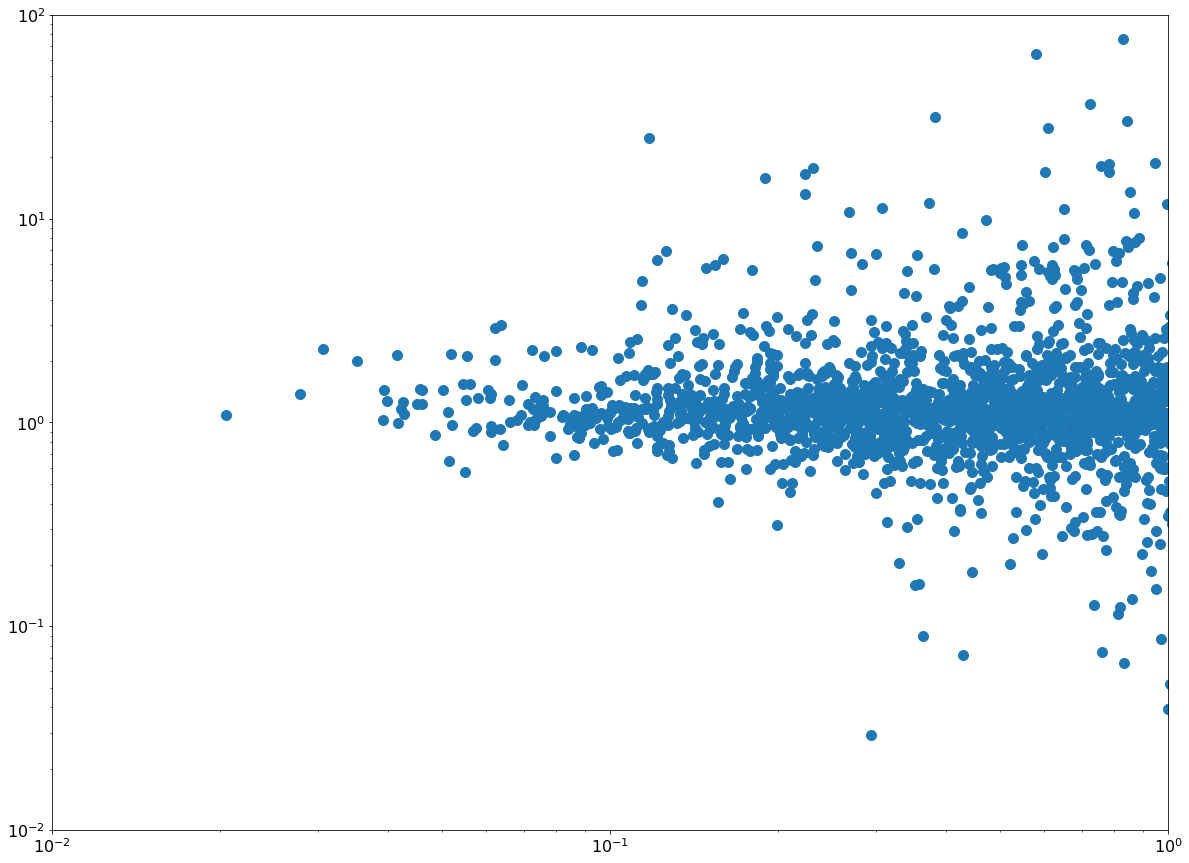

In [181]:
plt.scatter(sim_pn_bgcounts/pn_net_counts,
            sim_pn_fe_net/(sim_pn_cont1_net+sim_pn_cont2_net))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01, 1)
plt.ylim(0.01, 100)

In [ ]:
plt.hist2d()

In [99]:
sim_pn_fe_67_net = get_counts_enrange(sim_pn_netspec, [6.55, 6.85], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_67_src = get_counts_enrange(sim_pn_refinedspec, [6.55, 6.85], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_67_bg = get_counts_enrange(sim_pn_bg_refined, [6.55, 6.85], np.append(pn_emin, pn_emax[-1]))

sim_pn_fe_64_net = get_counts_enrange(sim_pn_netspec, [6.25, 6.55], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_64_src = get_counts_enrange(sim_pn_refinedspec, [6.25, 6.55], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_64_bg = get_counts_enrange(sim_pn_bg_refined, [6.25, 6.55], np.append(pn_emin, pn_emax[-1]))

sim_pn_fe_cont1_net = get_counts_enrange(sim_pn_netspec, [5.80, 6.10], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_cont1_src = get_counts_enrange(sim_pn_refinedspec, [5.80, 6.10], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_cont1_bg = get_counts_enrange(sim_pn_bg_refined, [5.80, 6.10], np.append(pn_emin, pn_emax[-1]))

sim_pn_fe_cont2_net = get_counts_enrange(sim_pn_netspec, [7.0, 7.3], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_cont2_src = get_counts_enrange(sim_pn_refinedspec, [7.0, 7.30], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_cont2_bg = get_counts_enrange(sim_pn_bg_refined, [7.00, 7.30], np.append(pn_emin, pn_emax[-1]))

1:80: E501 line too long (100 > 79 characters)
2:80: E501 line too long (104 > 79 characters)
3:80: E501 line too long (102 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
7:80: E501 line too long (102 > 79 characters)
9:80: E501 line too long (103 > 79 characters)
10:80: E501 line too long (107 > 79 characters)
11:80: E501 line too long (105 > 79 characters)
13:80: E501 line too long (101 > 79 characters)
14:80: E501 line too long (106 > 79 characters)


In [194]:
sim_pn_fe_67_net_2 = get_counts_enrange(sim_pn_netspec, [6.4, 7.0], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_67_src_2 = get_counts_enrange(sim_pn_refinedspec, [6.4, 7.0], np.append(pn_emin, pn_emax[-1]))
sim_pn_fe_67_bg_2 = get_counts_enrange(sim_pn_bg_refined, [6.4, 7.0], np.append(pn_emin, pn_emax[-1]))

1:80: E501 line too long (100 > 79 characters)
2:80: E501 line too long (104 > 79 characters)


In [209]:
sim_pn_fe_67_net_2

(array([ 15.48564951, 132.62893912, 168.94612921, ...,  67.88084711,
        658.18779447,  28.37864713]),
 1280,
 1400)

(1.0, 10.0)

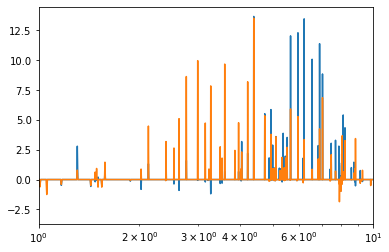

In [100]:
plt.plot(pn_ecentres, sim_pn_netspec[sim_pn_fe_64_bg[0] == 0].transpose())
plt.xscale('log')
plt.xlim(1.0, 10.0)


(array([  1.,   2.,   1.,   4.,   4.,  13.,  16.,  37.,  63.,  82., 107.,
        143., 205., 206., 253., 239., 316., 304., 421.,  77.]),
 array([-1.83622556, -1.73981658, -1.64340759, -1.54699861, -1.45058963,
        -1.35418064, -1.25777166, -1.16136268, -1.0649537 , -0.96854471,
        -0.87213573, -0.77572675, -0.67931776, -0.58290878, -0.4864998 ,
        -0.39009081, -0.29368183, -0.19727285, -0.10086387, -0.00445488,
         0.0919541 ]),
 <BarContainer object of 20 artists>)

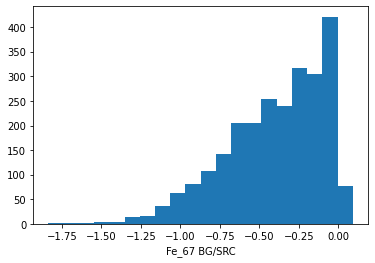

In [197]:
plt.figure()
plt.xlabel('Fe_67 BG/SRC')
plt.hist(np.log10(sim_pn_fe_67_bg_2[0]/sim_pn_fe_67_src_2[0]), bins=20)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(array([  2.,   1.,   4.,   5.,  11.,  21.,  44.,  78., 104., 164., 204.,
        270., 265., 304., 362., 394., 252.,   4.,   1.,   2.]),
 array([-1.91011396, -1.7931048 , -1.67609563, -1.55908647, -1.44207731,
        -1.32506815, -1.20805898, -1.09104982, -0.97404066, -0.8570315 ,
        -0.74002233, -0.62301317, -0.50600401, -0.38899484, -0.27198568,
        -0.15497652, -0.03796736,  0.07904181,  0.19605097,  0.31306013,
         0.43006929]),
 <BarContainer object of 20 artists>)

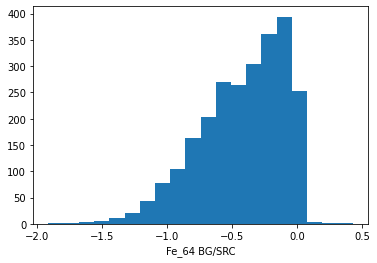

In [106]:
plt.figure()
plt.xlabel('Fe_64 BG/SRC')
plt.hist(np.log10(sim_pn_fe_64_bg[0]/sim_pn_fe_64_src[0]), bins=20)

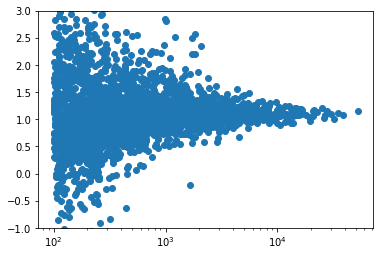

1:80: E501 line too long (102 > 79 characters)


In [149]:
plt.scatter(sim_pn_netcounts, 2*sim_pn_fe_64_net[0]/(sim_pn_fe_cont1_net[0] + sim_pn_fe_cont2_net[0]))
plt.ylim(-1, 3)
plt.xscale('log')

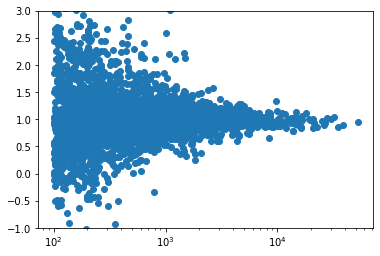

1:80: E501 line too long (102 > 79 characters)


In [198]:
plt.scatter(sim_pn_netcounts, 2*sim_pn_fe_67_net[0]/(sim_pn_fe_cont1_net[0] + sim_pn_fe_cont2_net[0]))
plt.ylim(-1, 3)
plt.xscale('log')

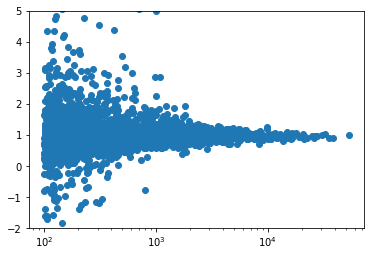

1:80: E501 line too long (102 > 79 characters)


In [223]:
plt.scatter(sim_pn_netcounts, sim_pn_fe_67_net_2[0]/(sim_pn_fe_cont1_net[0] + sim_pn_fe_cont2_net[0]))
plt.ylim(-2, 5)
plt.xscale('log')

In [160]:
sim_pn_netcounts_hist, sim_pn_netcount_bins_log = np.histogram(np.log10(
    pn_net_counts[pn_net_counts > 1]), bins=10)
sim_pn_bg_ratio_hist, sim_pn_bgratios_log = np.histogram(
    np.log10((sim_pn_bgcounts/pn_net_counts)[pn_net_counts > 1]), bins=10)

In [156]:
def get_expected_colors(counts_line_net, counts_cont1_net, counts_cont2_net,
                        net_counts, netcounts_bins):
    """Get expected color for given bins"""
    colors = 2*counts_line_net/(counts_cont1_net + counts_cont2_net)
    mean_colors = np.zeros(len(netcounts_bins)-1)
    colors_std = np.zeros(len(netcounts_bins)-1)
    for i, bin_edge in enumerate(netcounts_bins[:-1]):
        mean_colors[i], colors_std[i] = get_expected_color_bins(colors, net_counts, [bin_edge, netcounts_bins[i+1]])
    return mean_colors, colors_std
    

def get_expected_color_bins(colors, net_counts, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(net_counts >= bin_edges[0], net_counts < bin_edges[1]))
    bin_colors = colors[mask]
    return np.mean(bin_colors), np.std(bin_colors)

8:80: E501 line too long (116 > 79 characters)
10:1: W293 blank line contains whitespace
14:80: E501 line too long (90 > 79 characters)


In [179]:
sim_pn_netcount_bins = 10**sim_pn_netcount_bins_log

In [180]:
sim_pn_netcount_bins

array([  100.05702669,   187.1936013 ,   350.21472783,   655.20591908,
        1225.80452015,  2293.31982185,  4290.50123314,  8026.96625922,
       15017.40328823, 28095.59604941, 52563.18300984])

In [181]:
mean_colors_fe67, colors_std_fe67 = get_expected_colors(
    sim_pn_fe_67_net[0], sim_pn_fe_cont1_net[0], sim_pn_fe_cont2_net[0],
    sim_pn_netcounts, sim_pn_netcount_bins)

In [203]:
mean_colors_fe67_2, colors_std_fe67_2 = get_expected_colors(
    sim_pn_fe_67_net_2[0]/2.0, sim_pn_fe_cont1_net[0], sim_pn_fe_cont2_net[0],
    sim_pn_netcounts, sim_pn_netcount_bins)

Text(0, 0.5, 'Mean color')

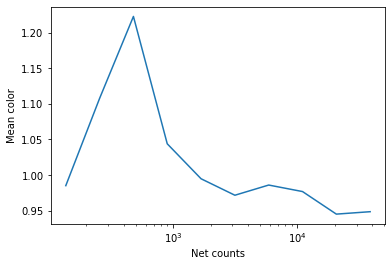

1:80: E501 line too long (98 > 79 characters)


In [184]:
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67)
plt.xlabel('Net counts')
plt.xscale('log')
plt.ylabel('Mean color')

Text(0, 0.5, 'Mean color')

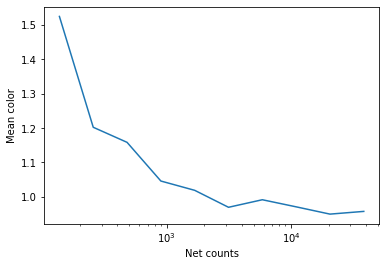

1:80: E501 line too long (100 > 79 characters)


In [204]:
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67_2)
plt.xlabel('Net counts')
plt.xscale('log')
plt.ylabel('Mean color')

Text(0, 0.5, 'Standard deviation in color')

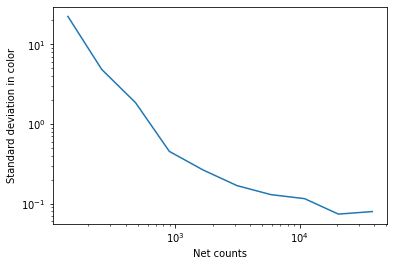

1:80: E501 line too long (97 > 79 characters)


In [207]:
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), colors_std_fe67)
plt.yscale('log')
plt.xlabel('Net counts')
plt.xscale('log')
plt.ylabel('Standard deviation in color')

Text(0, 0.5, 'Standard deviation in color')

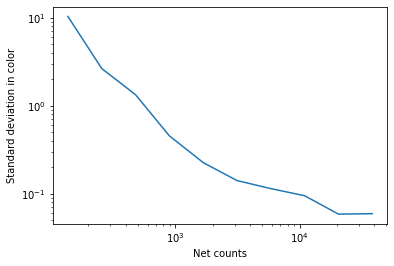

1:80: E501 line too long (99 > 79 characters)


In [206]:
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), colors_std_fe67_2)
plt.yscale('log')
plt.xlabel('Net counts')
plt.xscale('log')
plt.ylabel('Standard deviation in color')

## Checking colors of observed X-ray sources

In [5]:
([pn_src_num, mos_src_num], [pn_specs, mos_specs],
 [pn_bgs, mos_bgs]) = load_xmmspectra_raw(
    '../data/Galactic_highNH_combinedXMM/', background=True)

In [6]:
pn_emin, pn_emax, pn_ecentres = get_enbins_centres(
    '../XMM_responses/PN/epn_bu23_dY9.rmf.gz')
mos_emin, mos_emax, mos_ecentres = get_enbins_centres(
    '../XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf')

In [13]:
common_src_args_pn = []
common_src_args_mos = []
common_src_nums = []
for i, pn_src in enumerate(pn_src_num):
    if pn_src in mos_src_num:
        common_src_args_pn.append(i)
        common_src_nums.append(pn_src)
        common_src_args_mos.append(np.where(mos_src_num == pn_src)[0][0])

In [17]:
len(common_src_args_mos)

248

In [18]:
len(mos_src_num)

298

Text(0, 0.5, 'Normalized counts/s/keV')

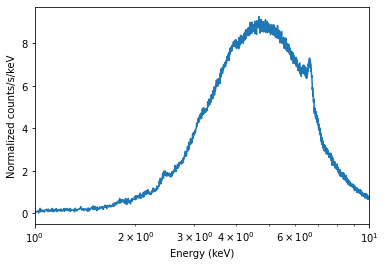

In [33]:
plt.plot(pn_ecentres, np.mean(pn_specs - pn_bgs, axis=0))
plt.xlim(1.0, 10)
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Normalized counts/s/keV')

(array([  1.,   1.,   0.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   2.,
          4.,   9.,  10.,  32.,  65., 113., 171.,  93.,  11.]),
 array([-1.64785312e+00, -1.56109436e+00, -1.47433560e+00, -1.38757685e+00,
        -1.30081809e+00, -1.21405934e+00, -1.12730058e+00, -1.04054183e+00,
        -9.53783072e-01, -8.67024316e-01, -7.80265561e-01, -6.93506805e-01,
        -6.06748050e-01, -5.19989294e-01, -4.33230539e-01, -3.46471783e-01,
        -2.59713028e-01, -1.72954272e-01, -8.61955166e-02,  5.63238947e-04,
         8.73219945e-02]),
 <BarContainer object of 20 artists>)

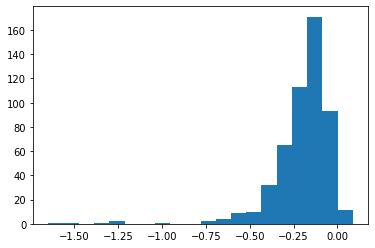

In [64]:
plt.hist(np.log10(np.sum(pn_bgs, axis=1)/np.sum(pn_specs, axis=1)), bins=20)

# Considering PN colors in observed data

In [19]:
pn_netspecs = pn_specs - pn_bgs
pn_netcounts = np.sum(pn_netspecs, axis=1)
pn_norm_netspec = (pn_netspecs.transpose()/pn_netcounts).transpose()

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([[0.00316728, 0.0285055 , 0.40541157, 0.69363386, 0.29455684,
         0.11085473, 0.04434189, 0.00950183, 0.00316728, 0.00633456],
        [0.        , 0.        , 0.13056941, 0.65937554, 0.46352142,
         0.21543953, 0.09139859, 0.01958541, 0.00652847, 0.01305694]]),
 array([0.06815636, 0.69336138, 1.3185664 , 1.94377141, 2.56897643,
        3.19418145, 3.81938646, 4.44459148, 5.0697965 , 5.69500151,
        6.32020653]),
 <a list of 2 BarContainer objects>)

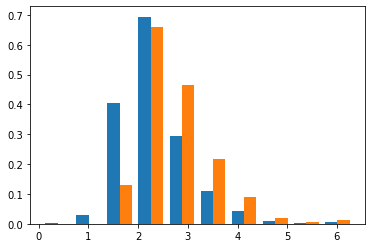

In [23]:
plt.hist([np.log10(pn_netcounts), np.log10(pn_netcounts[common_src_args_pn])], density=True)

(1.0, 10.0)

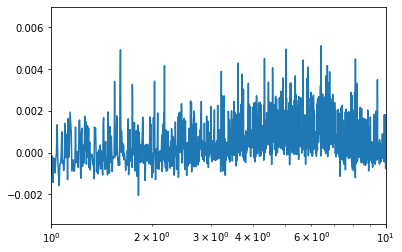

In [67]:
plt.plot(pn_ecentres, np.mean(pn_norm_netspec, axis=0))
plt.xscale('log')
plt.xlim(1.0, 10.0)

In [38]:
get_counts_enrange(pn_netspecs, [6.25, 6.55], np.append(pn_emin, pn_emax[-1]))

(array([ 6.04182303e+00,  2.62494138e+02,  1.33622299e-01,  5.34743154e+00,
         8.40184331e+00,  1.85008248e+02,  8.72454975e-02,  3.77557573e+00,
         1.31134314e+01,  2.62876739e+01,  3.02037687e+00,  8.31062173e+00,
         1.48481638e+00,  3.45712075e+00,  3.71083899e+01, -2.50741538e+00,
         2.18701086e-02,  9.06008647e+00,  4.37603280e+00,  2.02641032e+02,
         5.88369847e+00,  1.26465401e+01,  4.44716601e+01,  2.66228574e+03,
         7.44170682e+01,  5.40936302e+01,  1.89989491e+00,  2.16066511e+01,
         3.87324168e+01, -1.69991706e+00,  7.95499804e+00,  2.33778356e-01,
        -4.18179232e+00,  1.19696013e+02,  2.57413666e+01,  4.94588596e+02,
         3.08179592e+01,  3.84630436e+01,  1.80139892e+02,  1.23638544e+01,
         1.57091109e+02,  9.02913941e+00,  8.21958345e+00,  1.99720704e+02,
         1.57197602e+02,  1.53456284e+01, -9.89988134e-01,  2.41588137e+01,
         6.87033886e+01,  1.43733810e+01,  5.08714969e+00,  3.59934735e+00,
         2.8

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


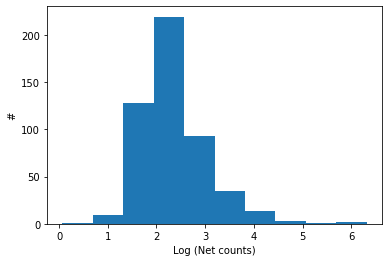

In [11]:
plt.hist(np.log10(pn_netcounts))
plt.xlabel('Log (Net counts)')
plt.ylabel('#')
plt.show()

In [118]:
# Considering spectra with > 50 counts only
if np.any(pn_netcounts < 100):
    pn_specs_refined = pn_specs[pn_netcounts >= 100]
    pn_bgs_refined = pn_bgs[pn_netcounts >= 100]
    pn_netspecs_refined = pn_netspecs[pn_netcounts >= 100]
    pn_norm_netspecs_refined = pn_norm_netspec[pn_netcounts >= 100]
    pn_netcounts_refined = pn_netcounts[pn_netcounts >= 100]
else:
    pn_specs_refined = pn_specs.copy()
    pn_bgs_refined = pn_bgs.copy()
    pn_netspecs_refined = pn_netspecs.copy()
    pn_norm_netspecs_refined = pn_norm_netspec.copy()
    pn_netcounts_refined = pn_netcounts.copy()


(1.0, 10.0)

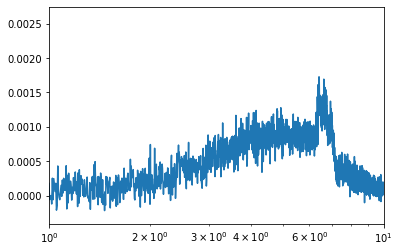

In [119]:
plt.plot(pn_ecentres, np.mean(pn_norm_netspecs_refined, axis=0))
plt.xscale('log')
plt.xlim(1.0, 10.0)

In [120]:
# Getting the energy indices for fe lines
print('Fe 6.4 low: ', np.where(pn_emin >= 6.25)[0][0],
      pn_ecentres[np.where(pn_emin >= 6.25)[0][0]])
print('Fe 6.4 high: ', np.where(pn_emax <= 6.55)[0][-1],
      pn_ecentres[np.where(pn_emax <= 6.55)[0][-1]])
print('Fe 6.7 low: ', np.where(pn_emin >= 6.55)[0][0],
      pn_ecentres[np.where(pn_emin >= 6.55)[0][0]])
print('Fe 6.7 high: ', np.where(pn_emax <= 6.85)[0][-1],
      pn_ecentres[np.where(pn_emax <= 6.85)[0][-1]])

Fe 6.4 low:  1250 6.2525
Fe 6.4 high:  1309 6.5475
Fe 6.7 low:  1310 6.5525
Fe 6.7 high:  1369 6.8475


In [121]:
print('Continuum 1 low: ', np.where(pn_emin >= 5.8)[0][0],
      pn_ecentres[np.where(pn_emin >= 5.8)[0][0]])
print('Continuum 1 high: ', np.where(pn_emax <= 6.1)[0][-1],
      pn_ecentres[np.where(pn_emax <= 6.1)[0][-1]])
print('Continuum 2 low: ', np.where(pn_emin >= 7.0)[0][0],
      pn_ecentres[np.where(pn_emin >= 7.0)[0][0]])
print('Continuum 2 high: ', np.where(pn_emax <= 7.3)[0][-1],
      pn_ecentres[np.where(pn_emax <= 7.3)[0][-1]])

Continuum 1 low:  1160 5.8025
Continuum 1 high:  1219 6.0975
Continuum 2 low:  1400 7.0025
Continuum 2 high:  1459 7.2975


In [21]:
pn_emin[1310]

6.55

In [122]:
def get_photons_enrange(count_array, en_low_index, en_high_index):
    return np.sum(count_array[:, en_low_index:en_high_index], axis=1)

In [123]:
pn_fe_64_line_net = get_photons_enrange(pn_netspecs_refined, 1250, 1310)
pn_fe_64_line_src = get_photons_enrange(pn_specs_refined, 1250, 1310)
pn_fe_64_line_bg = get_photons_enrange(pn_bgs_refined, 1250, 1310)

In [124]:
pn_fe_64_line_net

array([ 6.04182303e+00,  2.62494138e+02,  5.34743154e+00,  8.40184331e+00,
        1.85008248e+02,  3.77557573e+00,  1.31134314e+01,  2.62876739e+01,
        3.02037687e+00,  8.31062173e+00,  3.45712075e+00,  3.71083899e+01,
       -2.50741538e+00,  2.18701086e-02,  9.06008647e+00,  2.02641032e+02,
        5.88369847e+00,  1.26465401e+01,  4.44716601e+01,  2.66228574e+03,
        7.44170682e+01,  5.40936302e+01,  2.16066511e+01,  3.87324168e+01,
       -1.69991706e+00,  2.33778356e-01, -4.18179232e+00,  1.19696013e+02,
        2.57413666e+01,  4.94588596e+02,  3.08179592e+01,  3.84630436e+01,
        1.80139892e+02,  1.23638544e+01,  1.57091109e+02,  9.02913941e+00,
        8.21958345e+00,  1.99720704e+02,  1.57197602e+02,  1.53456284e+01,
        2.41588137e+01,  6.87033886e+01,  1.43733810e+01,  2.81326882e+00,
        5.90606373e+00,  3.64233352e+00,  4.70205257e+00,  5.66724836e+00,
        5.22326540e+01,  3.20863140e+01,  5.32026848e+01,  1.69302914e+01,
        8.30457110e+01,  

In [125]:
pn_fe_67_line_net = get_photons_enrange(pn_netspecs_refined, 1310, 1370)
pn_fe_67_line_src = get_photons_enrange(pn_specs_refined, 1310, 1370)
pn_fe_67_line_bg = get_photons_enrange(pn_bgs_refined, 1310, 1370)

In [210]:
pn_fe_67_line_net_2 = get_photons_enrange(pn_netspecs_refined, 1280, 1400)
pn_fe_67_line_src_2 = get_photons_enrange(pn_specs_refined, 1280, 1400)
pn_fe_67_line_bg_2 = get_photons_enrange(pn_bgs_refined, 1280, 1400)

In [126]:
pn_cont1_net = get_photons_enrange(pn_netspecs_refined, 1160, 1220)
pn_cont1_src = get_photons_enrange(pn_specs_refined, 1160, 1220)
pn_cont1_bg = get_photons_enrange(pn_bgs_refined, 1160, 1220)

In [127]:
pn_cont2_net = get_photons_enrange(pn_netspecs_refined, 1400, 1460)
pn_cont2_src = get_photons_enrange(pn_specs_refined, 1400, 1460)
pn_cont2_bg = get_photons_enrange(pn_bgs_refined, 1400, 1460)

In [140]:
pn_fe_64_line_bg[174] = 0
pn_fe_67_line_bg[174] = 0

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(array([ 1.,  2.,  0.,  1.,  4.,  1.,  2.,  3., 13., 16., 30., 33., 46.,
        72., 74., 33.,  7.,  3.,  2.,  1.]),
 array([-1.64753174, -1.54956322, -1.4515947 , -1.35362618, -1.25565765,
        -1.15768913, -1.05972061, -0.96175209, -0.86378357, -0.76581505,
        -0.66784653, -0.56987801, -0.47190949, -0.37394097, -0.27597245,
        -0.17800393, -0.08003541,  0.01793311,  0.11590164,  0.21387016,
         0.31183868]),
 <BarContainer object of 20 artists>)

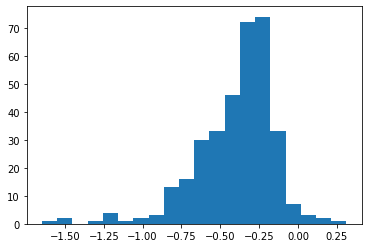

In [142]:
plt.hist(np.log10(pn_fe_67_line_bg/pn_fe_67_line_src), bins=20)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(array([ 1.,  1.,  1.,  0.,  0.,  2.,  0.,  4.,  3.,  8., 16., 25., 27.,
        57., 72., 57., 32., 27.,  8.,  3.]),
 array([-1.85838419, -1.75425829, -1.65013238, -1.54600648, -1.44188057,
        -1.33775467, -1.23362877, -1.12950286, -1.02537696, -0.92125106,
        -0.81712515, -0.71299925, -0.60887334, -0.50474744, -0.40062154,
        -0.29649563, -0.19236973, -0.08824383,  0.01588208,  0.12000798,
         0.22413388]),
 <BarContainer object of 20 artists>)

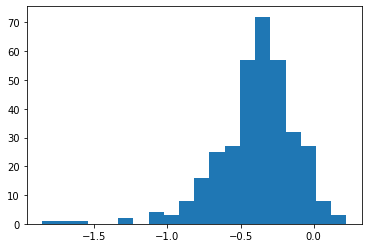

In [143]:
plt.hist(np.log10(pn_fe_64_line_bg/pn_fe_64_line_src), bins=20)

(100, 100000)

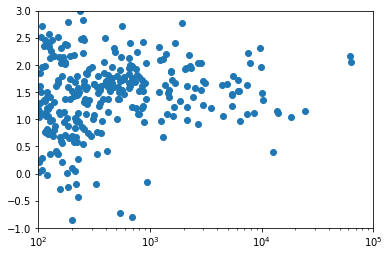

1:80: E501 line too long (84 > 79 characters)


In [158]:
plt.scatter(pn_netcounts_refined, 2*pn_fe_64_line_net/(pn_cont1_net + pn_cont2_net))
plt.xscale('log')
plt.ylim(-1, 3)
plt.xlim(100, 100000)

(100, 100000)

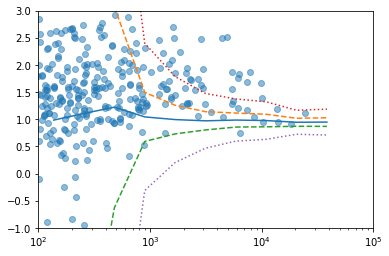

1:80: E501 line too long (95 > 79 characters)
2:80: E501 line too long (98 > 79 characters)
3:80: E501 line too long (123 > 79 characters)
4:80: E501 line too long (123 > 79 characters)
5:80: E501 line too long (124 > 79 characters)
6:80: E501 line too long (124 > 79 characters)


In [191]:
plt.scatter(pn_netcounts_refined, 2*pn_fe_67_line_net/(pn_cont1_net + pn_cont2_net), alpha=0.5)
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67)
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67+colors_std_fe67, ls='--')
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67-colors_std_fe67, ls='--')
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67+3*colors_std_fe67, ls=':')
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67-3*colors_std_fe67, ls=':')
plt.xscale('log')
plt.ylim(-1, 3)
plt.xlim(100, 100000)

(100, 100000)

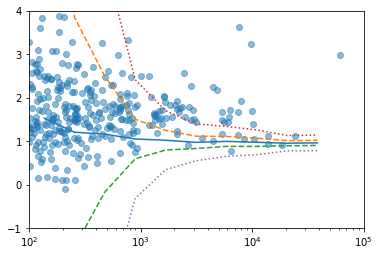

1:80: E501 line too long (95 > 79 characters)
2:80: E501 line too long (100 > 79 characters)
3:80: E501 line too long (127 > 79 characters)
4:80: E501 line too long (127 > 79 characters)
5:80: E501 line too long (128 > 79 characters)
6:80: E501 line too long (128 > 79 characters)


In [225]:
plt.scatter(pn_netcounts_refined, pn_fe_67_line_net_2/(pn_cont1_net + pn_cont2_net), alpha=0.5)
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67_2)
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67_2+colors_std_fe67_2, ls='--')
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67_2-colors_std_fe67_2, ls='--')
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67_2+3*colors_std_fe67_2, ls=':')
plt.plot(10**(0.5*(sim_pn_netcount_bins_log[:-1]+sim_pn_netcount_bins_log[1:])), mean_colors_fe67_2-3*colors_std_fe67_2, ls=':')
plt.xscale('log')
plt.ylim(-1, 4)

plt.xlim(100, 100000)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


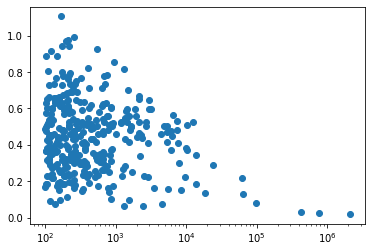

2:1: E265 block comment should start with '# '


In [220]:
plt.scatter(pn_netcounts_refined, pn_fe_67_line_bg_2/pn_fe_67_line_src_2)
#plt.scatter(pn_netcounts_refined, pn_fe_67_line_bg_2)
plt.xscale('log')

# Temp files

In [ ]:
def load_sim_xmmspec_temp(folder, background=False, num_sims=10000, basename=None):
    """Load simulated XMM data."""
    if basename is None:
        files = glob2.glob(folder + '*[!_bkg].fak')
    else:
        files = [folder + basename + str(i) for i in range(num_sims)]
    pn_specs = np.zeros((len(files), 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((len(files), 4096), dtype=np.float64)
    mos_specs = np.zeros((len(files), 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((len(files), 2400), dtype=np.float64)
    pn_mask = np.zeros(len(files), dtype=np.bool)
    mos_mask = np.zeros(len(files), dtype=np.bool)
    for i, file in enumerate(files):
        spec_data = fits.open(file)
        spectra = spec_data[1].data['counts']
        if background:
            bgfile = file[:-4] + '_bkg.fak'
            bgspec_data = fits.open(bgfile)
            bgspectra = bgspec_data[1].data['counts']*(
                spec_data[1].header['backscal'] /
                bgspec_data[1].header['backscal'])
        if len(spectra) == 4096:
            pn_mask[i] = True
            pn_specs[i] = spectra
            pn_bgspecs[i] = bgspectra
        else:
            mos_mask[i] = True
            mos_specs[i] = spectra
            mos_bgspecs[i] = bgspectra
    
    return ([np.where(pn_mask)[0], np.where(mos_mask)[0]],
            [pn_specs[pn_mask], mos_specs[mos_mask]],
            [pn_bgspecs[pn_mask], mos_bgspecs[mos_mask]])